<a href="https://colab.research.google.com/github/jasdeepbajaj/Image_Captioning/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import os
import sys
from pycocotools.coco import COCO
import urllib
import zipfile

import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('punkt')

import torch
import torch.utils.data as data
from PIL import Image
import numpy as np
from tqdm import tqdm
import random
import json
import pickle
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [57]:
os.makedirs('opt' , exist_ok=True)
os.chdir( '/content/opt' )
!git clone 'https://github.com/cocodataset/cocoapi.git'

fatal: destination path 'cocoapi' already exists and is not an empty directory.


In [58]:
os.chdir('/content/opt/cocoapi')

# Download the annotation :
annotations_trainval2014 = 'http://images.cocodataset.org/annotations/annotations_trainval2014.zip'
image_info_test2014 = 'http://images.cocodataset.org/annotations/image_info_test2014.zip'

urllib.request.urlretrieve(annotations_trainval2014 , filename = 'annotations_trainval2014.zip' )
urllib.request.urlretrieve(image_info_test2014 , filename= 'image_info_test2014.zip' )

('image_info_test2014.zip', <http.client.HTTPMessage at 0x7b2a85ee4190>)

In [59]:
with zipfile.ZipFile('annotations_trainval2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )

try:
  os.remove( 'annotations_trainval2014.zip' )
  print('zip removed')
except:
  None

with zipfile.ZipFile('image_info_test2014.zip' , 'r') as zip_ref:
  zip_ref.extractall( '/content/opt/cocoapi'  )

try:
  os.remove( 'image_info_test2014.zip' )
  print('zip removed')
except:
  None

zip removed
zip removed


In [60]:
dataDir = '/content/opt/cocoapi'
dataType = 'val2014'
instances_annFile = os.path.join(dataDir, 'annotations/instances_{}.json'.format(dataType))
coco = COCO(instances_annFile)

captions_annFile = os.path.join(dataDir, 'annotations/captions_{}.json'.format(dataType))
coco_caps = COCO(captions_annFile)

ids = list(coco.anns.keys())

loading annotations into memory...
Done (t=19.50s)
creating index...
index created!
loading annotations into memory...
Done (t=1.65s)
creating index...
index created!


http://images.cocodataset.org/val2014/COCO_val2014_000000097337.jpg


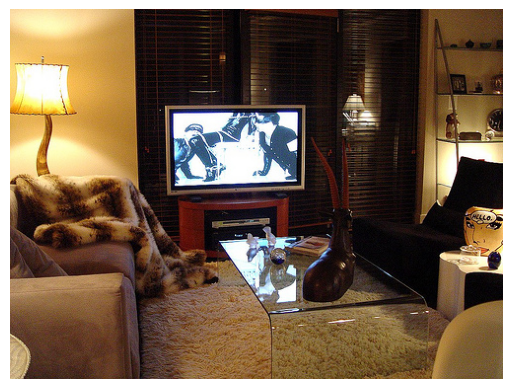

A TV sitting in a living room on top of a TV stand.
A TV is on in this unique and eclectic living room.
This is a nice living room set up with two couches and a television.
A living room with a chair, couch, coffee table and television.
empty room with the lights on and tv on


In [61]:
# pick a random image and obtain the corresponding URL
ann_id = np.random.choice(ids)
img_id = coco.anns[ann_id]['image_id']
img = coco.loadImgs(img_id)[0]
url = img['coco_url']

# print URL and visualize corresponding image
print(url)
I = io.imread(url)
plt.axis('off')
plt.imshow(I)
plt.show()

# load and display captions
annIds = coco_caps.getAnnIds(imgIds=img['id']);
anns = coco_caps.loadAnns(annIds)
coco_caps.showAnns(anns)

In [63]:
class Vocabulary(object):
  def __init__(self,
               vocab_threshold,
               vocab_file="./vocab.pkl",
               start_word = "",
               end_word = "",
               unk_word = "",
               annotations_file = "../cocoapi/annotations/captions_train2014.json",
               vocab_from_file = False):

    self.vocab_threshold = vocab_threshold
    self.vocab_file = vocab_file
    self.start_word = start_word
    self.end_word = end_word
    self.unk_word = unk_word
    self.annotations_file = annotations_file
    self.vocab_from_file = vocab_from_file
    self.get_vocab()

  def get_vocab(self):
    """Load the vocabulary from file or build the vocabulary from scratch"""
    if os.path.exists(self.vocab_file) and self.vocab_from_file:
      with open(self.vocab_file, 'rb') as f:
        vocab = pickle.load(f)
        self.word2idx = vocab.word2idx
        self.idx.word = vocab.idx2word
      print("Vocabulary Successfully Loaded from vocab.pkl file")

    else:
      self.build_vocab()
      # with open(self.vocab_file, 'wb') as f:
      #   pickle.dump(self, f)
      # print("Vocabulary Successfully Saved to vocab.pkl file")

  def build_vocab(self):
    """Populate the dictionaries for converting tokens to integers (and vice-versa)."""
    self.init_vocab()
    self.add_word(self.start_word)
    self.add_word(self.end_word)
    self.add_word(self.unk_word)
    self.add_captions()

  def init_vocab(self):
    """Initialize the dictionaries for converting tokens to integers (and vice-versa)."""
    self.word2idx = {}
    self.idx2word = {}
    self.idx = 0

  def add_word(self, word):
    """Add a token to the vocabulary."""
    if not word in self.word2idx:
      self.word2idx[word] = self.idx
      self.idx2word[self.idx] = word
      self.idx += 1

  def add_captions(self):

    coco = COCO(self.annotations_file)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
      caption = str(coco.anns[id]['caption'])
      tokens = nltk.tokenize.word_tokenize(caption.lower())
      counter.update(tokens)

      if i% 100000 == 0:
        print("[%d/%d] Tokenizing captions..." % (i, len(ids)))

    words = [word for word, cnt in counter.items() if cnt >= self.vocab_threshold]

    for i, word in enumerate(words):
      self.add_word(word)

  def __call__(self, word):
    if not word in self.word2idx:
      return self.word2idx[self.unk_word]

    return self.word2idx[word]

  def __len__(self):
    return len(self.word2idx)

In [ ]:
class CoCoDataset(data.Dataset):
  def __init__(self, transform, mode, batch_size, vocab_threshold, vocab_file, start_word, end_word,
               unk_word, annotations_file, vocab_from_file, img_folder):
    self.transform = transform
    self.mode = mode
    self.batch_size = batch_size
    pass
